In [1]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.feature as cfeature
import os
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import random

/Users/rachelstumpf/ulmo/ulmo/utils/image_utils.py:8: UserWarning: healpy not installed.  Not all functions will work!
  warnings.warn("healpy not installed.  Not all functions will work!")


In [2]:
# check extraction tables

table_2012 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2012.parquet')
table_2013 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2013.parquet')
table_2014 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2014.parquet')
table_2015 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2015.parquet')
table_2016 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2016.parquet')
table_2017 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2017.parquet')
table_2018 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2018.parquet')
table_2019 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2019.parquet')
table_2020 = pandas.read_parquet('/Users/rachelstumpf/Desktop/parquet/SST_L3S_VIIRS_2020.parquet')

table_all = pandas.concat([table_2012, table_2013, table_2014, table_2015,
                        table_2016, table_2017, table_2018, table_2019, table_2020])
table_all.reset_index(drop=True, inplace=True)

In [3]:
table_all = table_all.dropna(subset=['LL']) # now we have the matching L2 and L3S w/o days that were skipped

In [4]:
# hypothesis 1: L3S smoothed out fields, this would result in lower DT and high LL
# BUT did it smooth it in a good way (reduce clouds) or did it remove features
# ways to test: in areas that we know should be clear, visually look for temp changes

# mediterranean

med = table_all[
    (table_all['lon'] >= 5) & (table_all['lat'] <= 40) &
    (table_all['lat'] >= 30) & (table_all['lat'] <= 40)
]

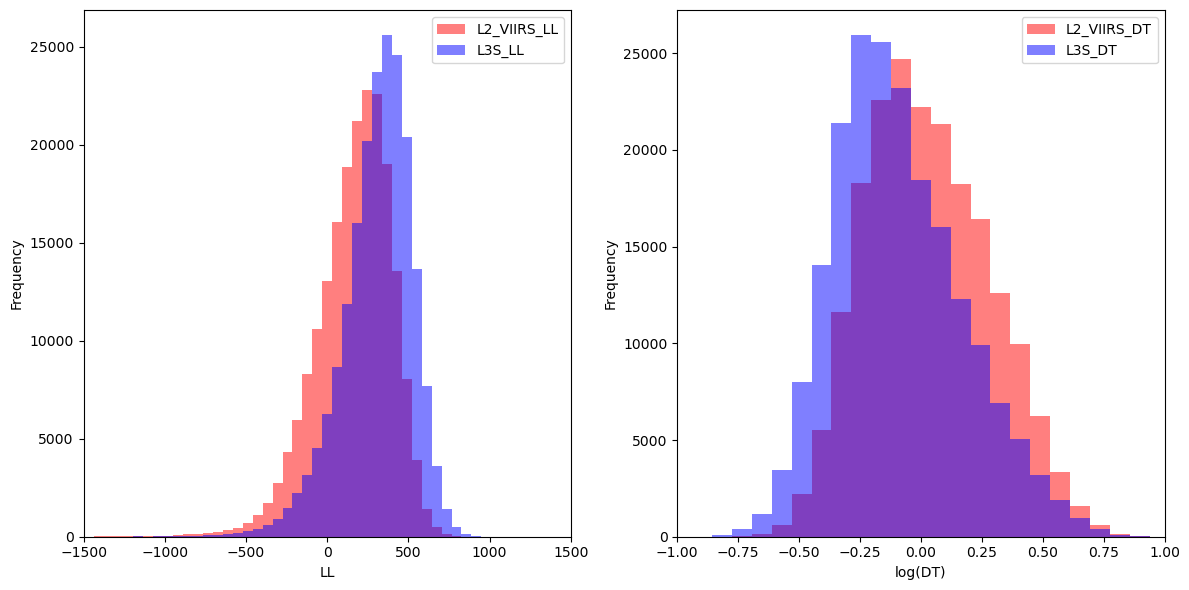

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
bin_edges = np.linspace(-1500, 1500, 50)
plt.hist(med['VIIRS_LL'], bins=bin_edges, alpha=0.5, label='L2_VIIRS_LL', color='red')
plt.hist(med['LL'], bins=bin_edges, alpha=0.5, label = 'L3S_LL', color = 'blue')
plt.xlabel('LL')
plt.ylabel('Frequency')
plt.xlim(-1500, 1500)
plt.legend()

plt.subplot(1, 2, 2)
bin_edges = np.linspace(-2,2, 50)
plt.hist(np.log10(med['VIIRS_DT']), bins=bin_edges, alpha=0.5, label='L2_VIIRS_DT', color='red')
plt.hist(np.log10(med['DT']), bins=bin_edges, alpha=0.5, label='L3S_DT', color='blue')
plt.xlabel('log(DT)')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()

plt.tight_layout()
plt.show()
# so even in this area that should be really clear to begin with, the L3S data is still increasing LL and decreasing DT

In [6]:
middle_atlantic = table_all[
    (table_all['lon'] >= -45) & (table_all['lon'] <= -25) &
    (table_all['lat'] >= 30) & (table_all['lat'] <= 40)
]

In [7]:
middle_atlantic.loc[:,'VIIRS_clear_fraction'] = 1 - middle_atlantic.loc[:,'VIIRS_clear_fraction']
diff = middle_atlantic.loc[:,'clear_fraction'] - middle_atlantic.loc[:,'VIIRS_clear_fraction']
middle_atlantic.loc[:,'clear_frac_diff'] = diff

med.loc[:,'VIIRS_clear_fraction'] = 1 - med.loc[:,'VIIRS_clear_fraction']
diff = med.loc[:,'clear_fraction'] - med.loc[:,'VIIRS_clear_fraction']
med.loc[:,'clear_frac_diff'] = diff

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_50341/1978808342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_atlantic.loc[:,'clear_frac_diff'] = diff
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_50341/1978808342.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med.loc[:,'clear_frac_diff'] = diff


/Users/rachelstumpf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rachelstumpf/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


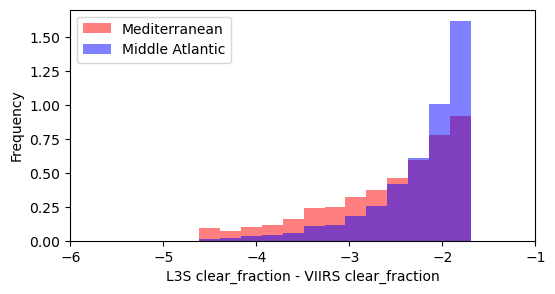

In [8]:
plt.figure(figsize=(6, 3))

bin_edges = np.linspace(-10, 1, 50)
plt.hist(np.log10(med['clear_frac_diff']), bins=bin_edges, alpha=0.5, label='Mediterranean', color='red', density = True)
plt.hist(np.log10(middle_atlantic['clear_frac_diff']), bins=bin_edges, alpha=0.5, label = 'Middle Atlantic', color = 'blue', density = True)
plt.xlabel('L3S clear_fraction - VIIRS clear_fraction')
plt.ylabel('Frequency')
plt.xlim(-6, -1)
plt.legend()

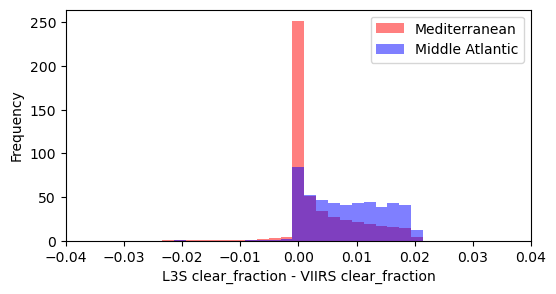

In [9]:
plt.figure(figsize=(6, 3))

bin_edges = np.linspace(-0.05, 0.05, 50)
plt.hist(med['clear_frac_diff'], bins=bin_edges, alpha=0.5, label='Mediterranean', color='red', density = True)
plt.hist(middle_atlantic['clear_frac_diff'], bins=bin_edges, alpha=0.5, label = 'Middle Atlantic', color = 'blue', density = True)
plt.xlabel('L3S clear_fraction - VIIRS clear_fraction')
plt.ylabel('Frequency')
plt.xlim(-0.04, 0.04)
plt.legend()

# clear fractions are usually positive (L3S is more clear)
# Mediterranean is more likely to have exactly the same clear fraction for VIIRS and L3S (likely 1, is completely clear)
# I guess this doesn't tell us about clouds, look at that visually

In [10]:
med_similarDT = med[
    (med['DT'] >= -0.2) & (med['DT'] <= 0.2)
]

In [11]:
random_rows_indices = random.sample(range(len(med_similarDT)), 10)
random_rows = med_similarDT.iloc[random_rows_indices]

In [12]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(None, None), show=False, set_aspect=None, clbl=None,
               ax=None, title=None):
    if cm is None:
        _, cm = plotting.load_palette()
    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})  # 'fontsize': 20})
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    return ax

In [13]:
def plot_cutout_set(data):
    length = len(data)
    fig, axes = plt.subplots(len(data), 2, figsize=(10, 2.5*length))

    for i, (_, row) in enumerate(data.iterrows()):
        pp_file = row['VIIRS_pp_file']
        pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        viirs_year = viirs_datetime.year
        local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        viirs = image_utils.grab_image(matching_row, local_file=local_file)
        viirs = viirs[0, ...]
    
        pp_file = row['pp_file']
        pp_idx = row['pp_idx']
        local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        l3s = image_utils.grab_image(matching_row, local_file=local_file)
        l3s = l3s[0, ...]

        viirs_min = np.min(viirs)
        viirs_max = np.max(viirs)
        l3s_min = np.min(l3s)
        l3s_max = np.max(l3s)

        vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))

        show_image(viirs, ax=axes[i, 0], title=f'VIIRS - Row {i+1}', vmnx=vmnx)
        show_image(l3s, ax=axes[i, 1], title=f'L3S - Row {i+1}', vmnx=vmnx)

    plt.tight_layout()

    plt.show()

In [14]:
def show_image2(img, cm=None, cbar=True, flipud=True, vmnx=(None, None), vmin=None, vmax=None, show=False, set_aspect=None, clbl=None, ax=None, title=None):
    if cm is None:
        _, cm = plotting.load_palette()
    #
    if flipud:
        img = np.flipud(img)

    ax = sns.heatmap(img, xticklabels=[], vmin=vmin, vmax=vmax, ax=ax, yticklabels=[], cmap=cm, cbar=cbar, cbar_kws={'label': clbl})
    # Set the title
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    #
    return ax

def plot_cutout_set2(data):
    length = len(data)
    fig, axes = plt.subplots(len(data), 2, figsize=(10, 2.5*length))

    for i, (_, row) in enumerate(data.iterrows()):
        pp_file = row['VIIRS_pp_file']
        pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        viirs_year = viirs_datetime.year
        local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        viirs = image_utils.grab_image(matching_row, local_file=local_file)
        viirs = viirs[0, ...]
    
        pp_file = row['pp_file']
        pp_idx = row['pp_idx']
        local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
        matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
        l3s = image_utils.grab_image(matching_row, local_file=local_file)
        l3s = l3s[0, ...]

        viirs_min = np.min(viirs)
        viirs_max = np.max(viirs)
        l3s_min = np.min(l3s)
        l3s_max = np.max(l3s)

        vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))
        vmin, vmax = -1, 1

        # Get pp_idx and VIIRS_datetime for title and caption
        pp_idx = row['pp_idx']
        viirs_pp_idx = row['VIIRS_pp_idx']
        viirs_datetime = row['VIIRS_datetime']

        # Create the title and caption for VIIRS image
        viirs_title = f'VIIRS: DT={row["VIIRS_DT"]:.2f} LL={row["VIIRS_LL"]:.2f}'
        viirs_caption = f'VIIRS_pp_idx: {viirs_pp_idx}'

        # Create the title and caption for L3S image
        l3s_title = f'L3S: DT={row["DT"]:.2f} LL={row["LL"]:.2f}'
        l3s_caption = f'pp_idx: {pp_idx}\nVIIRS_datetime: {viirs_datetime}'

        show_image2(viirs, ax=axes[i, 0], title=viirs_title, vmnx=vmnx, vmin=vmin, vmax=vmax)
        axes[i, 0].text(0.5, -0.15, viirs_caption, ha='center', va='center', transform=axes[i, 0].transAxes, fontsize=8)

        show_image2(l3s, ax=axes[i, 1], title=l3s_title, vmnx=vmnx, vmin=vmin, vmax=vmax)
        axes[i, 1].text(0.5, -0.15, l3s_caption, ha='center', va='center', transform=axes[i, 1].transAxes, fontsize=8)

    plt.tight_layout()

    plt.show()

In [15]:
#plot_cutout_set(random_rows)

In [16]:
#plot_cutout_set2(random_rows)

In [17]:
table_all.loc[:,'diff_DT'] = table_all.loc[:,"VIIRS_DT"] - table_all.loc[:,'DT']
table_all.loc[:,'diff_LL'] = table_all.loc[:,"VIIRS_LL"] - table_all.loc[:,'LL']

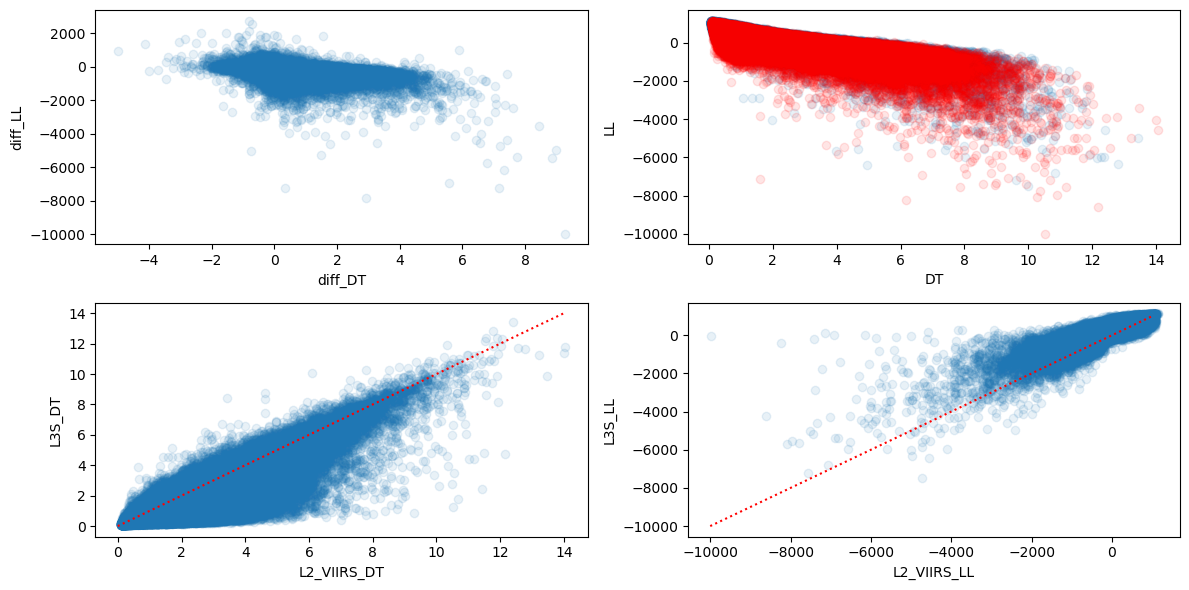

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(table_all['diff_DT'], table_all['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(table_all['DT'], table_all['LL'], alpha = 0.1) # x,y
plt.scatter(table_all['VIIRS_DT'], table_all['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(table_all['VIIRS_DT'], table_all['DT'], alpha = 0.1) # x,y
plt.plot([0, 14], [0, 14], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(table_all['VIIRS_LL'], table_all['LL'], alpha = 0.1) # x,y
plt.plot([-10000, 1000], [-10000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [19]:
blacksea = table_all[
    (table_all['lat'] >= 43) & (table_all['lat'] <= 44) &
    (table_all['lon'] >= 33) & (table_all['lon'] <= 34)
]

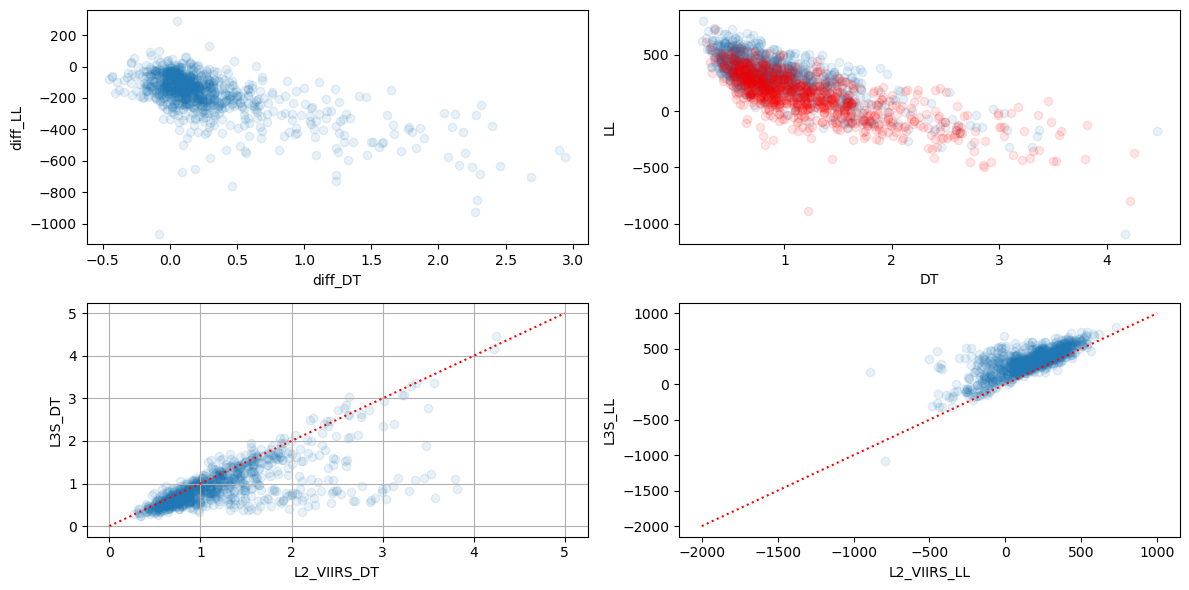

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(blacksea['diff_DT'], blacksea['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(blacksea['DT'], blacksea['LL'], alpha = 0.1) # x,y
plt.scatter(blacksea['VIIRS_DT'], blacksea['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(blacksea['VIIRS_DT'], blacksea['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(blacksea['VIIRS_LL'], blacksea['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [24]:
table_all.loc[:,'local_timedelta'] = pandas.to_timedelta(table_all.loc[:,'lon'] / 15, unit='H')
table_all.loc[:,'local_suntime'] = table_all.loc[:,'VIIRS_datetime'] + table_all.loc[:,'local_timedelta']
normalized_date = table_all.loc[:,'local_suntime'].dt.normalize()
time_component_timedelta = pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.hour, unit='h') + pandas.to_timedelta(table_all['local_suntime'].dt.minute, unit='m') + pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.second, unit='s')

table_all.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta

In [25]:
blacksea.loc[:,'local_timedelta'] = pandas.to_timedelta(blacksea.loc[:,'lon'] / 15, unit='H')
blacksea.loc[:,'local_suntime'] = blacksea.loc[:,'VIIRS_datetime'] + blacksea.loc[:,'local_timedelta']
normalized_date = blacksea.loc[:,'local_suntime'].dt.normalize()
time_component_timedelta = pandas.to_timedelta(blacksea.loc[:,'local_suntime'].dt.hour, unit='h') + pandas.to_timedelta(blacksea['local_suntime'].dt.minute, unit='m') + pandas.to_timedelta(table_all.loc[:,'local_suntime'].dt.second, unit='s')

blacksea.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta
blacksea['L2_local_suntime_hours'] = blacksea['L2_local_suntime'].dt.hour + blacksea['L2_local_suntime'].dt.minute / 60 + blacksea['L2_local_suntime'].dt.second / 3600

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_50341/2193756681.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacksea.loc[:,'L2_local_suntime'] = normalized_date + time_component_timedelta
/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_50341/2193756681.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacksea['L2_local_suntime_hours'] = blacksea['L2_local_suntime'].dt.hour + blacksea['L2_local_suntime'].dt.minute / 60 + blacksea['L2_local_suntime'].dt.second / 3600


In [26]:
nighttime_start = 22.0
nighttime_end = 6.0

nighttime_cutouts = blacksea[
    (blacksea['L2_local_suntime_hours'] >= nighttime_start) |
    (blacksea['L2_local_suntime_hours'] <= nighttime_end)
]

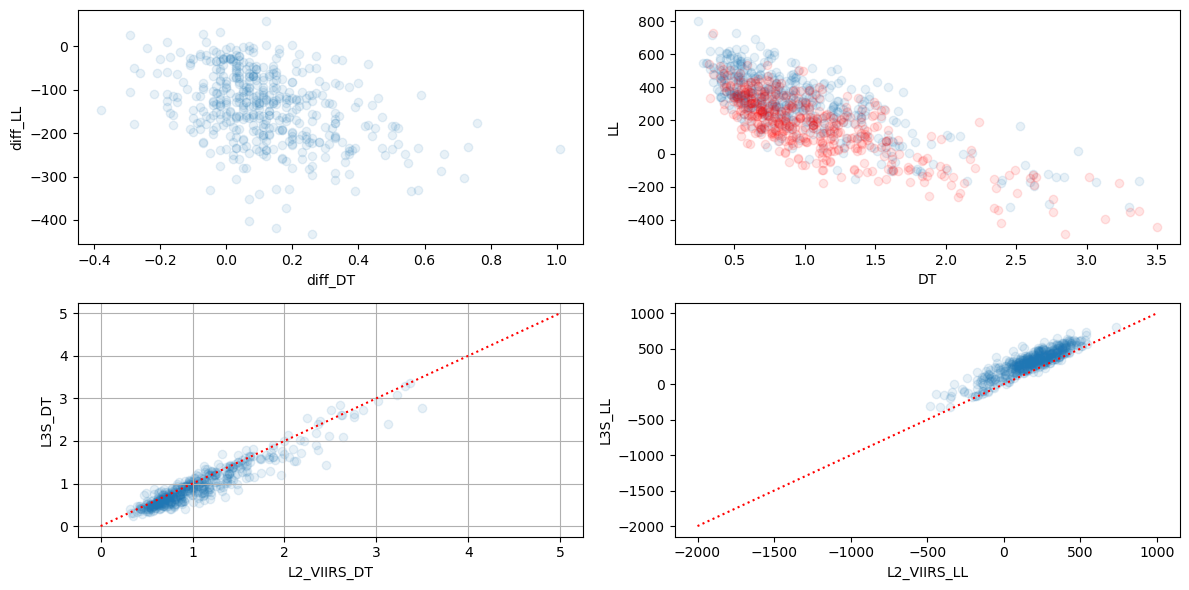

In [27]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(nighttime_cutouts['diff_DT'], nighttime_cutouts['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(nighttime_cutouts['DT'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(nighttime_cutouts['VIIRS_LL'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [28]:
nighttime_cutouts_5 = nighttime_cutouts.head(5)

In [26]:
#plot_cutout_set(nighttime_cutouts_5) # add title w log likelihood & DT, row /column number, all same range

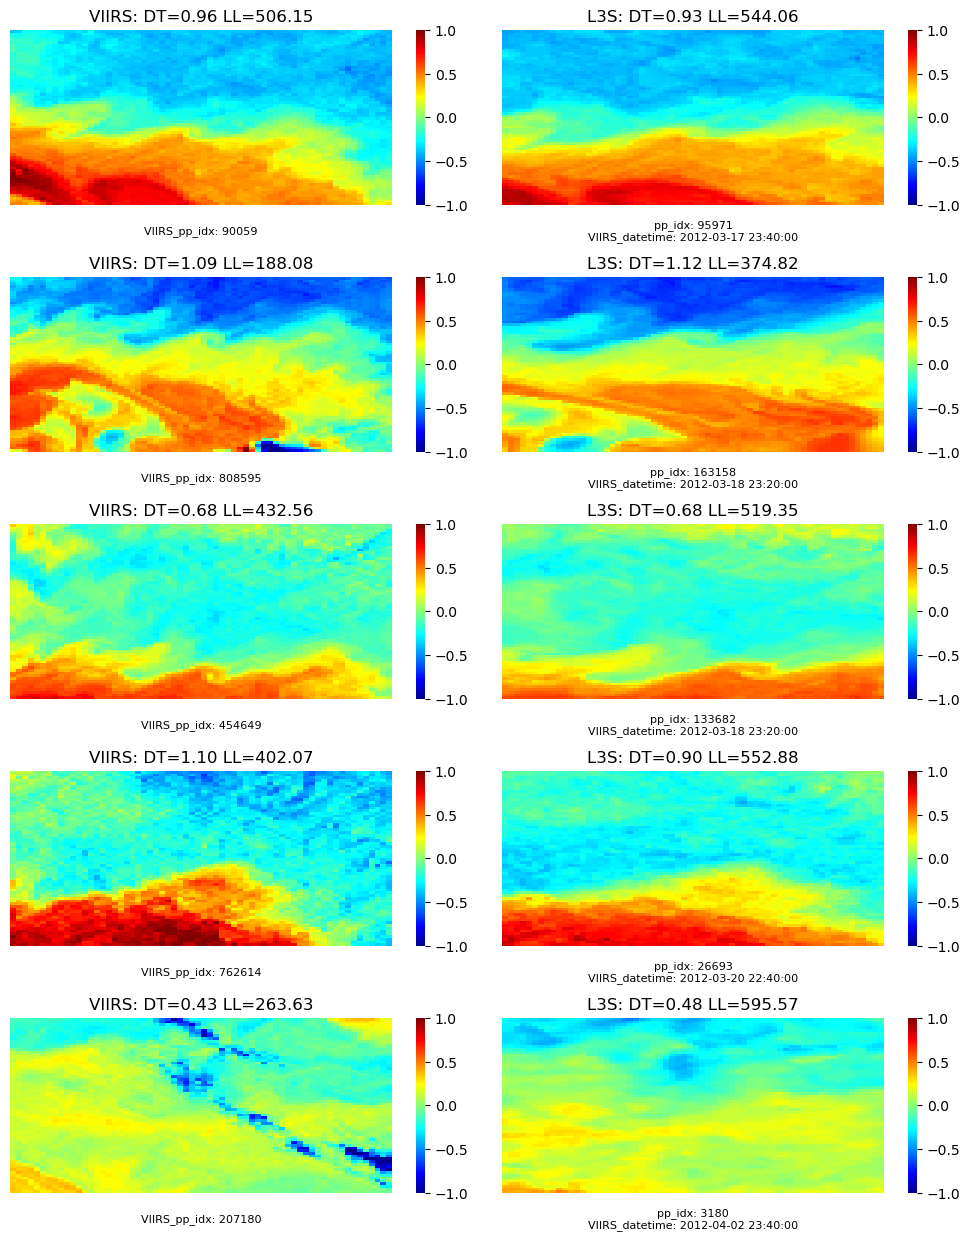

In [29]:
plot_cutout_set2(nighttime_cutouts_5)

In [30]:
row = nighttime_cutouts_5.iloc[4]

pp_file = row['VIIRS_pp_file']
pp_idx = row['VIIRS_pp_idx']
viirs_year = row['VIIRS_datetime'].year

local_file = f"/Users/rachelstumpf/Desktop/VIIRS/VIIRS_{viirs_year}_95clear_192x192_preproc_viirs_std.h5"
matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
viirs = image_utils.grab_image(matching_row, local_file=local_file)
#viirs = viirs[0, ...]
    
pp_file = row['pp_file']
pp_idx = row['pp_idx']
local_file = f"/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_{viirs_year}_preproc.h5"
matching_row = pandas.DataFrame({'pp_file': [pp_file], 'pp_idx': [pp_idx]})
l3s = image_utils.grab_image(matching_row, local_file=local_file)
#l3s = l3s[0, ...]

In [31]:
l3s = l3s.reshape((4096,))
viirs = viirs.reshape((4096,))

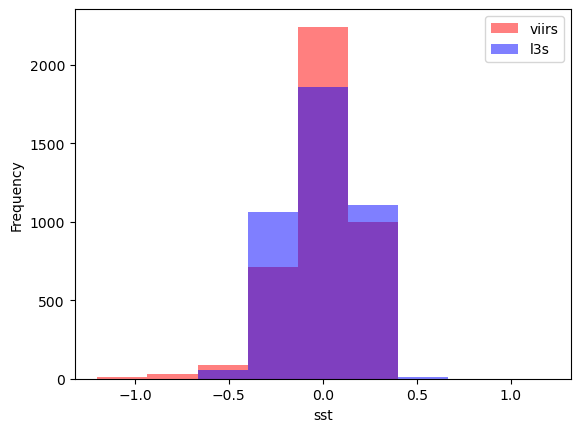

In [32]:
bin_edges = np.linspace(-1.2,1.2,10)
plt.hist(viirs, bins=bin_edges, alpha=0.5, label='viirs', color='red', density = False)
plt.hist(l3s, bins=bin_edges, alpha=0.5, label='l3s', color='blue', density = False)

plt.xlabel('sst')
plt.ylabel('Frequency')
plt.legend()
plt.show()
# sum 100 of these together to see if it tightens
# SOMETHING WRONG W HISTOGRAM

In [33]:
coefficients = np.polyfit(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], deg=1)

m, b = coefficients

def linear_fit(x):
    return m * x + b

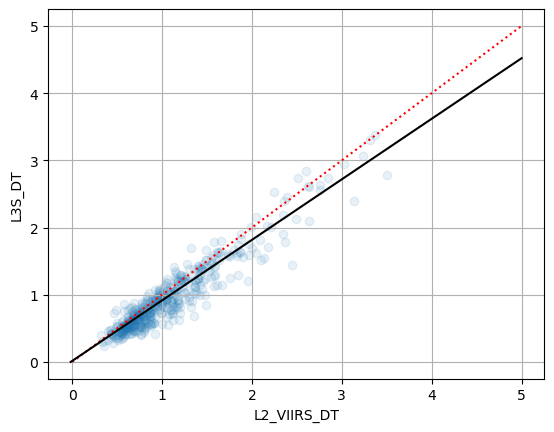

In [34]:
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.plot([b,5],[0,m*5+b], color='black')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')
plt.show()

In [35]:
new_blacksea = blacksea[
    (blacksea['VIIRS_DT'] >= 1.5) & (blacksea['VIIRS_DT'] <= 2)  &
    (blacksea['DT'] >= 0.5) & (blacksea['DT'] <= 0.6)
]

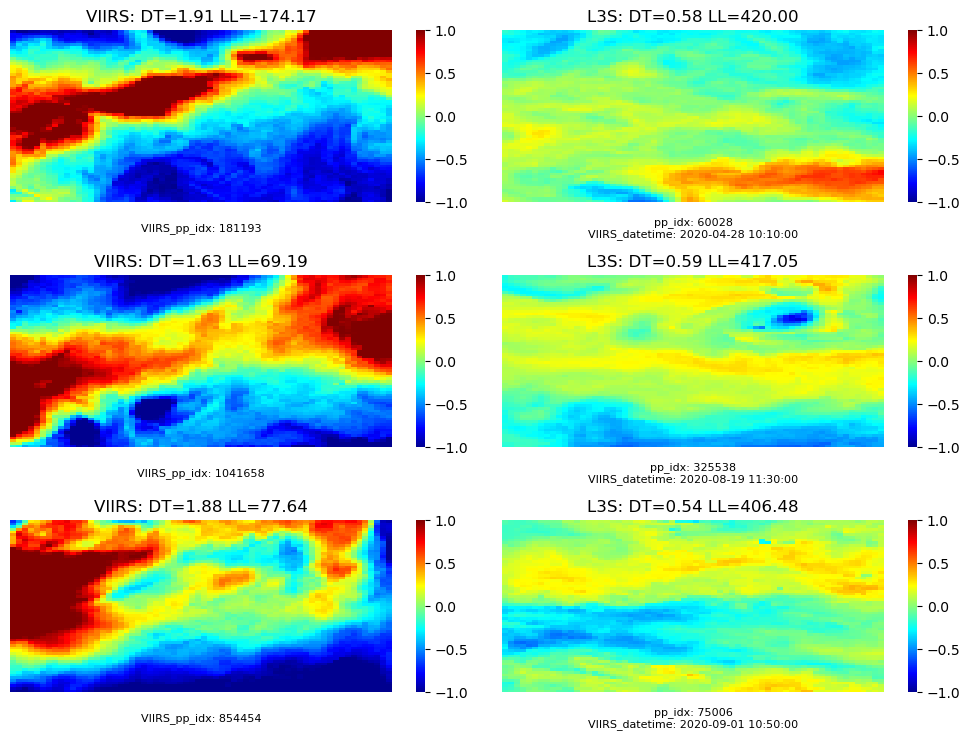

In [36]:
plot_cutout_set2(new_blacksea)

In [37]:
table_all.loc[:,'L2_local_suntime_time'] = table_all.loc[:,'L2_local_suntime'].dt.time
table_all['L2_local_suntime_seconds'] = table_all['L2_local_suntime'].dt.hour * 3600 + table_all['L2_local_suntime'].dt.minute * 60 + table_all['L2_local_suntime'].dt.second
table_all['L2_local_suntime_hours'] = table_all['L2_local_suntime'].dt.hour + table_all['L2_local_suntime'].dt.minute / 60 + table_all['L2_local_suntime'].dt.second / 3600

# Convert 'diff_DT' to total hours
#table_all['diff_DT_hours'] = table_all['diff_DT'].dt.total_seconds() / 3600

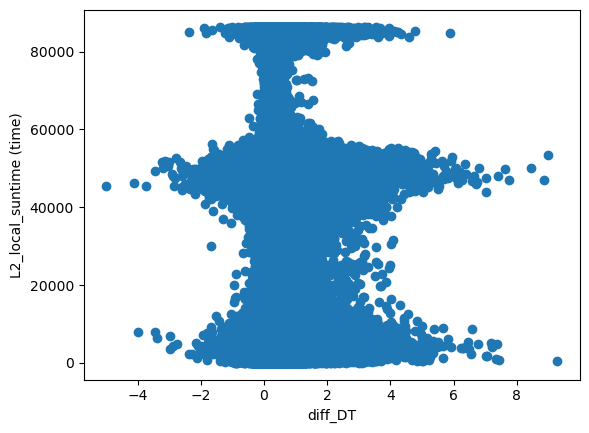

In [38]:
plt.scatter(table_all['diff_DT'], table_all['L2_local_suntime_seconds'])

plt.xlabel('diff_DT')
plt.ylabel('L2_local_suntime (time)')

plt.show()

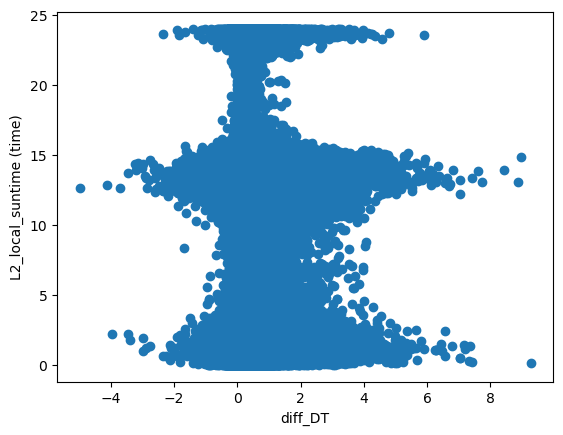

In [39]:
plt.scatter(table_all['diff_DT'], table_all['L2_local_suntime_hours'])

plt.xlabel('diff_DT')
plt.ylabel('L2_local_suntime (time)')

plt.show()

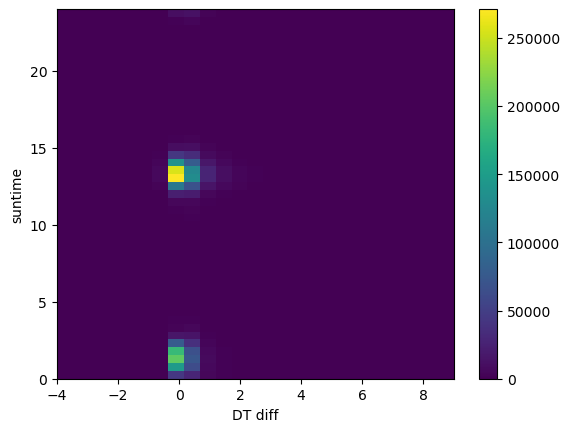

In [40]:
x_bins = np.linspace(-4, 9, 26)  # 26 bins for half-degree increments
y_bins = np.linspace(0, 24, 48)  # 48 bins for half-hour increments

plt.hist2d(table_all['diff_DT'], table_all['L2_local_suntime_hours'], bins=[x_bins, y_bins], cmap='viridis')

plt.xlabel('DT diff')
plt.ylabel('suntime')

plt.colorbar()
plt.show()

In [42]:
observation_matrix = np.empty((len(y_edges) - 1, len(x_edges) - 1), dtype=int)
for y_index in range(len(y_edges) - 1):
    for x_index in range(len(x_edges) - 1):
        observation_matrix[y_index, x_index] = hist[x_index, y_index]

/var/folders/_r/zbkcbh452sgfkpxvpxh952x80000gv/T/ipykernel_50341/1617145754.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(observation_matrix), origin='lower', aspect='auto', cmap='viridis', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])


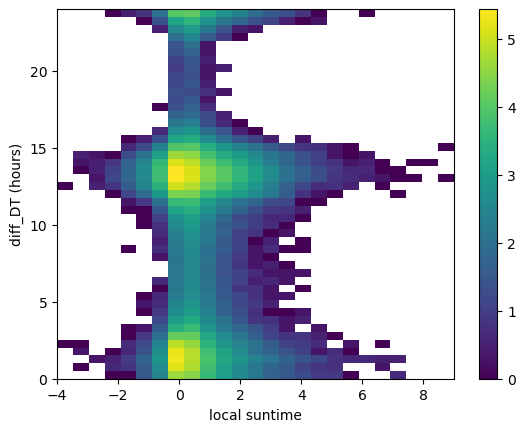

In [43]:
plt.imshow(np.log10(observation_matrix), origin='lower', aspect='auto', cmap='viridis', extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]])

# Set labels for the x and y axes
plt.xlabel('local suntime')
plt.ylabel('diff_DT (hours)')

# Show the colorbar
plt.colorbar()
plt.show()

In [44]:
nighttime_start = 22.0
nighttime_end = 6.0

nighttime_cutouts = table_all[
    (table_all['L2_local_suntime_hours'] >= nighttime_start) |
    (table_all['L2_local_suntime_hours'] <= nighttime_end)
]

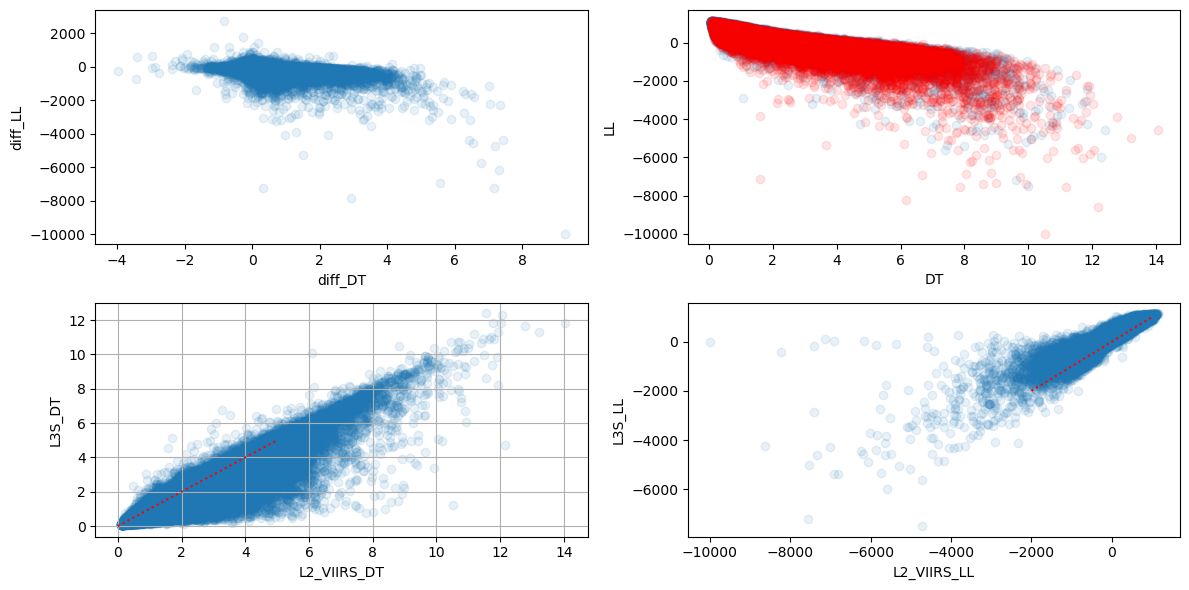

In [45]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.scatter(nighttime_cutouts['diff_DT'], nighttime_cutouts['diff_LL'], alpha = 0.1) # x,y
plt.xlabel('diff_DT')
plt.ylabel('diff_LL')

plt.subplot(2, 2, 2)
plt.scatter(nighttime_cutouts['DT'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['VIIRS_LL'], alpha = 0.1, color = 'red') 
plt.xlabel('DT')
plt.ylabel('LL')

plt.subplot(2, 2, 3)
plt.scatter(nighttime_cutouts['VIIRS_DT'], nighttime_cutouts['DT'], alpha = 0.1) # x,y
plt.plot([0, 5], [0, 5], color='red', linestyle='dotted')
plt.grid(True)
#plt.xlim(6, 12)
plt.xlabel('L2_VIIRS_DT')
plt.ylabel('L3S_DT')

plt.subplot(2, 2, 4)
plt.scatter(nighttime_cutouts['VIIRS_LL'], nighttime_cutouts['LL'], alpha = 0.1) # x,y
plt.plot([-2000, 1000], [-2000, 1000], color='red', linestyle='dotted')
plt.xlabel('L2_VIIRS_LL')
plt.ylabel('L3S_LL')

plt.tight_layout()
plt.show()

In [46]:
# check on datetime, it seems I selected on GMT of VIIRS and not local suntime
date_to_check = table_all[
    (table_all['pp_idx'] == 26693) &
    (table_all['VIIRS_pp_idx'] == 762614)
]

In [47]:
pp_file = "s3://sst-l3s/PreProc/L3S_VIIRS144_2012_preproc.h5"
pp_idx = 26693

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
L3S_far_ex = image_utils.grab_image(matching_row, local_file = "/Users/rachelstumpf/Desktop/PreProc/L3S_VIIRS144_2012_preproc.h5")
#L3S_far_ex = np.flipud(np.fliplr(L3S_row0))[0,...]
L3S_far_ex = L3S_far_ex[0,...]

# get matching VIIRS
pp_file = "s3://viirs/PreProc/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5"
pp_idx = 762614 # these cannot be simply read into the function because now they start with VIIRS_ so do not match

matching_row = pandas.DataFrame({
    'pp_file': [pp_file],
    'pp_idx': [pp_idx]
})
VIIRS_far_ex = image_utils.grab_image(matching_row, local_file = "/Users/rachelstumpf/Desktop/VIIRS/VIIRS_2012_95clear_192x192_preproc_viirs_std.h5")
VIIRS_far_ex = VIIRS_far_ex[0,...]

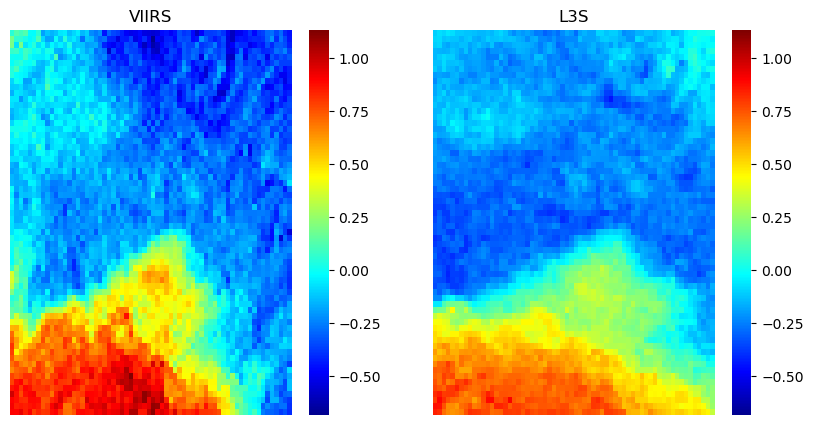

In [48]:
def show_image(img: np.ndarray, cm=None, cbar: bool = True, flipud=True,
               vmnx=(None, None), show=False, set_aspect=None, clbl=None,
               ax=None, title=None):
    """Display the cutout image
    Args:
        img (np.ndarray): cutout image
        cm ([type], optional): Color map to use. Defaults to None.
            If None, load the heatmap above
        cbar (bool, optional): If True, show a color bar. Defaults to True.
        flipud (bool, optional): If True, flip the image up/down. Defaults to True.
        vmnx (tuple, optional): Set vmin, vmax. Defaults to None
        set_aspect (str, optional):
            Passed to ax.set_aspect() if provided
        ax (matplotlib.Axis, optional): axis to use for the plot
        title (str, optional): title for the plot
    Returns:
        matplotlib.Axis: axis containing the plot
    """
    if cm is None:
        _, cm = plotting.load_palette()
    #
    ax = sns.heatmap(np.flipud(img), xticklabels=[],
                     vmin=vmnx[0], vmax=vmnx[1], ax=ax,
                     yticklabels=[], cmap=cm, cbar=cbar,
                     cbar_kws={'label': clbl})  # 'fontsize': 20})
    # Set the title
    if title is not None:
        ax.set_title(title)

    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    #
    return ax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Calculate the minimum and maximum values for both images
viirs_min = np.min(VIIRS_far_ex)
viirs_max = np.max(VIIRS_far_ex)
l3s_min = np.min(L3S_far_ex)
l3s_max = np.max(L3S_far_ex)

# Use the same vmin and vmax for both images
vmnx = (min(viirs_min, l3s_min), max(viirs_max, l3s_max))

viirs = show_image(VIIRS_far_ex, ax=axes[0], title= 'VIIRS', vmnx=vmnx)

l3s = show_image(L3S_far_ex, ax=axes[1], title='L3S',vmnx=vmnx)

plt.show()

In [49]:
march19 = xarray.open_dataset('/Users/rachelstumpf/Desktop/20120319120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')
march21 = xarray.open_dataset('/Users/rachelstumpf/Desktop/20120321120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc')

In [50]:
march19 = march19.squeeze('time')['sea_surface_temperature']
march21 = march21.squeeze('time')['sea_surface_temperature']

In [51]:
lat = date_to_check['lat'].iloc[0]
lon = date_to_check['lon'].iloc[0]

In [52]:
window_size_degrees = 64 * 0.02

march19 = march19.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))
march21 = march21.sel(lat=slice(lat + window_size_degrees / 2, lat - window_size_degrees / 2),
                     lon=slice(lon - window_size_degrees / 2, lon + window_size_degrees / 2))

In [53]:
#show_image(march19, title = 'L3S March 19, 2012')
#show_image(march21, title = 'L3S March 21, 2012')